In [1]:
import itertools
from pathlib import Path

import minisom
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import shapely
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
Path.cwd()


from plotly.colors import sample_colorscale, make_colorscale, DEFAULT_PLOTLY_COLORS
from plotly.subplots import make_subplots
from plotly.figure_factory import create_dendrogram

from scipy.spatial.distance import sqeuclidean
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
from IPython.display import IFrame, Image, HTML, display_html
#%matplotlib

# Parameters

In [2]:
data_path = Path.cwd().parent / 'data.csv'
input_columns = ['pH', 'Ca', 'Mg', 'Na', 'K', 'HCO3', 'Cl', 'SO4']

som_nx = None  # Set to None to determine these automatically (PCA)
som_ny = None
som_sigma =  1.7
som_learning_rate = 0.5
som_activation_distance = 'euclidean'
som_topology = 'hexagonal'
som_neighborhood_function = 'gaussian'

In [3]:
som_random_seed = 10
som_max_iterations = 5000


#run_nbclust = True
max_clusters = 10
number_of_clusters = 4  # Set to None to pick the optimal number automatically

# Visualization
#features_colorscale = 'spectral'
#features_colorscale = 'RdBu'
features_colorscale = 'RdYlBu'
pio.templates.default = 'plotly_white'
plotly_interactive = True

# Fixed colorscales
# force_feature_colorscale_to_01 = True
# specialized_colorscales = {
#      "sil_w2": "spectral",
#      "cat_exch1": "spectral"
#     # "cat_exch1": make_colorscale(
#     #     ["rgb(255, 0, 0)", "rgb(0, 255, 0)", "rgb(0, 0, 255)"],
#     #     [               0,              0.3,              1.0],
# }

In [4]:
# Convenience function to allow changing between interactive and static images
# Needed to show figures on GitHub notebook preview
def show_figure(fig: go.Figure):
    global fig_count
    if plotly_interactive:
        return fig
    else:
        return Image(data=fig.to_image(format='png', scale=2))

In [5]:
# Read input data
df = pd.read_csv(data_path)

#df.describe()
#print(f"Input data shape:   {df.shape}")

In [6]:
#df

In [7]:
# Apply data transformation

# Normalization:
def apply_normalization(arr):
    data_min = arr.min(axis=0)
    data_range = arr.max(axis=0) - data_min

    return (arr - data_min) / data_range

    
# Transforms data into a range [-1, 1].
    #return ((2*(arr - data_min))/ data_range)-1


# # Standardization
# def apply_standardization(arr):
#     data_mean = arr.mean(axis=0)
#     data_std = arr.std(axis=0)
#     return (arr - data_mean) / data_std

# # Sigmoid
# def apply_sigmoid(arr):
#     return 1 / (1 + np.exp(-arr))


input_array = df[input_columns].values

## Uncomment the appropriate transform
transformed_data = apply_normalization(input_array)
# transformed_data = apply_standardization(input_array)
#transformed_data = apply_sigmoid(input_array)

#print(f"Transformed data shape: {transformed_data}")


# SOM model

In [8]:
# Derive SOM dimensions
if som_nx is None or som_ny is None:
    recommended_nodes = 5 * np.sqrt(len(df))
    print(f"Recommended number of nodes: {recommended_nodes:.0f}")
   
    # "Naive" approach: square root of the number of samples (with round-off)
    # final_nx = np.round(np.sqrt(som_m)).astype(int)
    # final_ny = np.round(som_m / som_nx).astype(int)

    # Perform PCA analysis
    pca = PCA(n_components=2)
    pca.fit(transformed_data)

    # Calculate the ratio between the first two principal components
    pca_ratio = pca.explained_variance_[0] / pca.explained_variance_[1]
    final_nx = np.round(np.sqrt(recommended_nodes * pca_ratio)).astype(int)
    final_ny = np.round(recommended_nodes / final_nx).astype(int)
    print(f"Using PCA to determine SOM dimensions: {final_nx} x {final_ny} (PCA ratio: {pca_ratio:.2f})")
else:
    final_nx, final_ny = som_nx, som_ny
    print(f"Using fixed SOM dimensions: {final_nx} x {final_ny}")

Recommended number of nodes: 50
Using PCA to determine SOM dimensions: 9 x 6 (PCA ratio: 1.68)


In [9]:

# Set up model
som = minisom.MiniSom(
    final_nx,
    final_ny,
    len(input_columns),
    sigma=som_sigma,
    learning_rate=som_learning_rate,
    activation_distance=som_activation_distance,
    topology=som_topology,
    neighborhood_function=som_neighborhood_function,
    random_seed=som_random_seed,
)

# Train
som.train(transformed_data, som_max_iterations)

# Extract data
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()
win_map = som.win_map(transformed_data, return_indices = True)

Quantization error: 0.10572088955832633
Topographic error : 0.039215686274509776


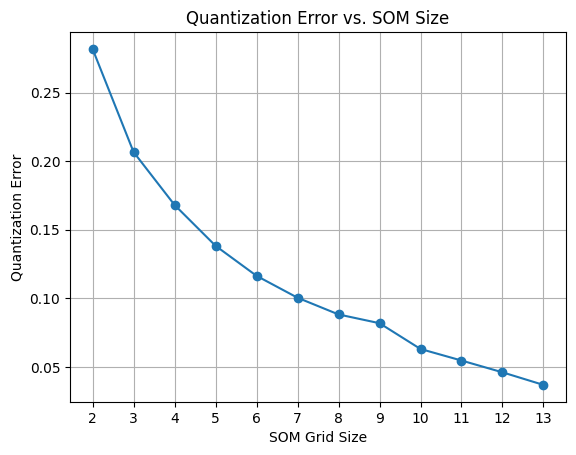

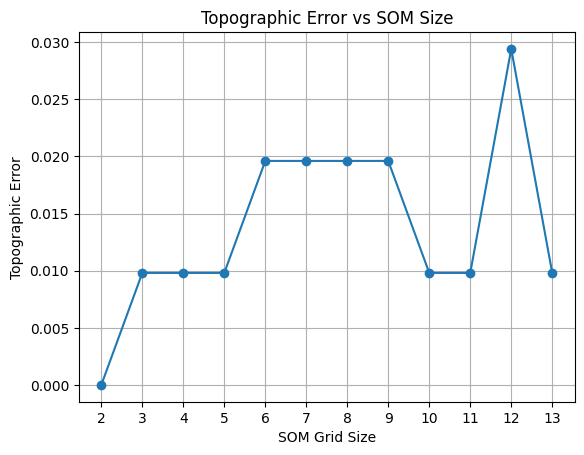

In [10]:
# Print quantization and topographic errors for the trained model
print(f"Quantization error: {som.quantization_error(transformed_data)}")
print(f"Topographic error : {som.topographic_error(transformed_data)}")


# Range of SOM grid sizes to test
grid_sizes = range(2, 14)

# Store QE and TE for each grid size
qe_values = []
te_values = []

for size in grid_sizes:
    # Initialize and train SOM
    som = minisom.MiniSom(size, size, transformed_data.shape[1], som_sigma, som_learning_rate)
    som.random_weights_init(transformed_data)
    som.train_random(transformed_data, som_max_iterations)

    # Calculate and store QE
    qe = som.quantization_error(transformed_data)
    qe_values.append(qe)

     # Calculate and store TE
    te = som.topographic_error(transformed_data)
    te_values.append(te)
   

# Plotting QE vs SOM size
plt.plot(grid_sizes, qe_values, marker='o')
plt.xlabel("SOM Grid Size")
plt.ylabel("Quantization Error")
plt.title("Quantization Error vs. SOM Size")
plt.xticks(grid_sizes)
plt.grid(True)
plt.show()


# Plotting TE vs SOM size
plt.plot(grid_sizes, te_values, marker='o')
plt.xlabel("SOM Grid Size")
plt.ylabel("Topographic Error")
plt.title("Topographic Error vs SOM Size")
plt.xticks(grid_sizes)
plt.grid(True)
plt.show()

#Printing QE and TE values

# for size in grid_sizes:
#     print(f"Quantization error: Som size {qe_values, size}\n")

# for size in grid_sizes:
#     print(f"Topographic error: Som size {te_values, size}\n")

# #Plot U-Matrix
# fig = px.imshow(
#     umatrix,
#     color_continuous_scale=features_colorscale,
#     title="U-Matrix",
#     labels=dict(x="X", y="Y"),
    
# )
#     # print("\n")
#     # print("\t\n")
#     # print("\n")

In [58]:
# Setup input to clustering and dendrogram plot
mij = np.meshgrid(np.arange(final_nx), np.arange(final_ny), indexing='ij')
cells_ij = np.column_stack((mij[0].flat, mij[1].flat))
labels = [(i, j) for i, j in cells_ij]
flat_weights = weights.reshape(-1, len(input_columns)) 

# Change to ward?
links = hierarchy.linkage(flat_weights, method='ward', metric='euclidean')


# Clustering

In [59]:
cluster_results = []

for i in range(2, max_clusters):
    flat_labels = hierarchy.fcluster(links, i, 'maxclust')
    #dbi = davies_bouldin_score(flat_weights, flat_labels) if len(set(flat_labels)) == i else None
    sil = silhouette_score(flat_weights, flat_labels) if len(set(flat_labels)) == i else None
    cluster_results.append({
        "Number of clusters": i,
        #"DBI": dbi,
        "Silhouette": sil,
        "labels": flat_labels,
    })

cluster_df = pd.DataFrame.from_dict(cluster_results)


#dbi_optimal_cluster = cluster_df.iloc[cluster_df['DBI'].idxmin()]
sil_optimal_cluster = cluster_df.iloc[cluster_df['Silhouette'].idxmax()]

if number_of_clusters is None:
    selected_cluster = sil_optimal_cluster
    #selected_cluster = dbi_optimal_cluster
else:
    selected_cluster = cluster_df[cluster_df['Number of clusters'] == number_of_clusters].iloc[0]

In [ ]:
#print(f"Optimal number of clusters based on DBI        : {dbi_optimal_cluster['Number of clusters']}")
print(f"Optimal number of clusters based on Silhouette : {sil_optimal_cluster['Number of clusters']}")
print()

if number_of_clusters is None:
    print(f"Number of clusters picked based on Silhouette     : {selected_cluster['Number of clusters']}")
    # print(f"Number of clusters picked based on DBI         : {selected_cluster['Number of clusters']}")
else:
    print(f"Number of clusters fixed to                    : {number_of_clusters}")

Optimal number of clusters based on Silhouette : 2

Number of clusters fixed to                    : 4


In [61]:
# fig = px.line(cluster_df, x='Number of clusters', y='DBI', markers=True)
# fig.layout.title = "Davies-Bouldin Index (lower is better)"
# fig.layout.yaxis.spikesnap = "hovered data"
# fig.layout.yaxis.spikemode = "across"
# fig.layout.yaxis.spikethickness = 1
#fig

In [62]:
fig = px.line(cluster_df, x='Number of clusters', y='Silhouette', markers=True)
fig.layout.title = "Silhouette score (higher is better)"
fig.layout.yaxis.spikesnap = "hovered data"
fig.layout.yaxis.spikemode = "across"
fig.layout.yaxis.spikethickness = 1
#fig
show_figure(fig)

Using distance threshold 1.452 to get 4 clusters


C:\Users\vegard\AppData\Local\Temp\ipykernel_34528\3762030862.py:52: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



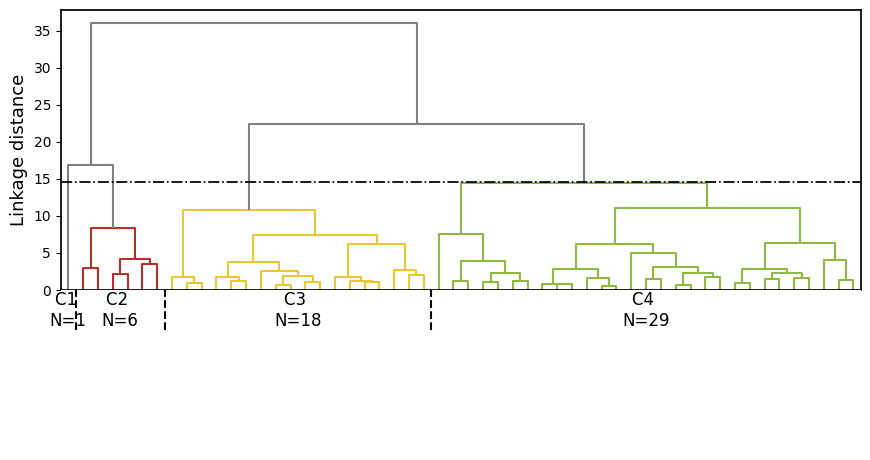

In [ ]:
final_n_clusters = number_of_clusters or int(selected_cluster['Number of clusters'])

# Keep in mind that this plot is for the SOM features and NOT the original data (by design)

fig = plt.figure(figsize=(10, 8))

# Axis settings
left, bottom, width, height = 0.1, 0.35, 0.8, 0.35
ax1 = fig.add_axes([left, bottom, width, height])

# Customize the colors of the nine clusters
colors=['#BA2F29', '#E9C832', '#8EBA42', '#67ACE6']
hierarchy.set_link_color_palette(colors)

# Plot the dendrogram using the built-in scipy function
# Ideally, we could use maxclust directly, like we do with fcluster:
#   hierarchy.fcluster(links, i, 'maxclust')
# However, this is not supported in dendrogram, so we need to find
# the appropriate distance threshold to get the desired number of clusters
max_d = 0.7
for _ in range(20):
    # Don't plot yet, this is just to get the number of clusters
    dendrogram = hierarchy.dendrogram(
        links,
        leaf_rotation=90,
        leaf_font_size=0,
        color_threshold=max_d,
        above_threshold_color='grey',
        no_plot=True
    )
    d_clusts = len(set(dendrogram['leaves_color_list']))
    if d_clusts == final_n_clusters:
        break
    if d_clusts < final_n_clusters:
        max_d *= 0.8
    if d_clusts > final_n_clusters:
        max_d *= 1.2
else:
    # This can happen if e.g. two clusters are very close together
    print(f"Warning: Could not find a distance threshold to get {final_n_clusters} clusters")

# Main dendrogram plot
print(f"Using distance threshold {max_d:.3f} to get {d_clusts} clusters")
dendrogram = hierarchy.dendrogram(
        links,
        leaf_rotation=90,
        leaf_font_size=0,
        color_threshold=max_d,
        above_threshold_color='grey',
)
hierarchy.set_link_color_palette(None)
ax1.axhline(y=max_d, linestyle='-.', color='k', lw=1.25) 
ax1.set_ylabel('Linkage distance', fontsize=13)
ax1.set_yticklabels([0, 5, 10, 15, 20, 25, 30, 35], fontsize=10)
ax1.set_xticks([])
ax1.spines['top'].set_linewidth(1.25)
ax1.spines['bottom'].set_linewidth(1.25)
ax1.spines['left'].set_linewidth(1.25)
ax1.spines['right'].set_linewidth(1.25)
# ax1.text(150, 20.5, '$Phenon$' + ' ' + '$Line$', fontsize=12)


# The bottom figure showing the cluster names
left, bottom, width, height = 0.1, 0.15, 0.8, 0.2
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim(0, (len(links) + 1) * 10)
ax2.set_ylim(0, 2)


# Dot line to split each cluster 
unique, counts = np.unique(dendrogram['leaves_color_list'], return_counts=True)
cluster_size_dict = dict(zip(unique, counts))
cluster_size = [
    cluster_size_dict[clr]
    for clr in dict.fromkeys(dendrogram['leaves_color_list'])
]
boundaries = np.cumsum(cluster_size) * 10
for i in range(final_n_clusters - 1):
    ax2.plot([boundaries[i], boundaries[i]], [1.5, 2.0], linestyle='--', color='k', lw=1.5) 

ax2.set_xticks([])
ax2.set_yticks([])
    
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')

# Add cluster labels for arbitrary number of clusters
extended_boundaries = np.concatenate([[0], boundaries])
for i in range(final_n_clusters):
    left_bound = extended_boundaries[i]
    right_bound = extended_boundaries[i + 1]
    center_x = left_bound + (right_bound - left_bound) / 2
    ax2.text(center_x, 1.5, f'C{i+1} \nN={cluster_size[i]}', ha='center', va='bottom', fontsize=12)

plt.show()

In [17]:
# Optimal number of lables
node_labels = selected_cluster['labels'].reshape(final_nx, final_ny)

# For nbclust result, use this
#node_labels = nbclust_lables.reshape(final_nx, final_ny)

# Sample labels
sample_ij = [None] * len(df)
sample_label = [-1] * len(df)
for key, value in win_map.items():
    for ix in value:
        sample_ij[ix] = key
        sample_label[ix] = node_labels[key]

df['ij'] = sample_ij
df['cluster_label'] = sample_label


In [18]:
n_cols = 8
for lab, sub_df in df.groupby('cluster_label'):
    print(f"Cluster {lab}: {len(sub_df)} samples")
    for i, s in enumerate(sub_df['Sample']):
        print(f"  {s:19}", end="")
        if i % n_cols == n_cols - 1:
            print()
    print("\n")
    

Cluster 1: 7 samples
  sample41             sample43             sample44             sample45             sample46             sample47             sample93           

Cluster 2: 25 samples
  sample31             sample32             sample33             sample34             sample35             sample36             sample40             sample55           
  sample57             sample59             sample71             sample72             sample73             sample74             sample75             sample76           
  sample77             sample78             sample96             sample97             sample98             sample99             sample100            sample101          
  sample102          

Cluster 3: 68 samples
  sample1              sample2              sample3              sample4              sample5              sample6              sample7              sample8            
  sample9              sample10             sample11             sample12             s

In [19]:
t = ""
for lab, sub in df.groupby('cluster_label'):
    t += f"<h2>Cluster {lab}</h2>"
    t += " ".join(sub["Sample"])
    t += sub.describe().to_html()
#display_html(t, raw=True)

# Plotting and Visualization

In [20]:
# Create hexagons for visualization
def hexagon(_xx, _yy, radius):
    # Returns a NX x NY x 6 x 2 array of hexagon coordinates
    hex_xy = np.zeros((_xx.shape[0], _xx.shape[1], 7, 2))
    for i in range(7):
        theta = np.pi / 6 + 2 * np.pi * i / 6
        hex_xy[:, :, i, 0] = _xx + radius * np.cos(theta)
        hex_xy[:, :, i, 1] = _yy + radius * np.sin(theta)
    return hex_xy


hexagons = hexagon(xx, yy, 0.5)
hexagons.shape

(9, 6, 7, 2)

In [21]:

# Cluster polygons
node_hexagons = hexagon(xx, yy, np.sqrt(3) / 3 + 0.001).reshape(-1, 7, 2)
cluster_boundaries = {}
for c in np.unique(node_labels):
    matches = node_labels.flatten() == c
    joined_polygon = shapely.union_all([shapely.Polygon(p) for p in node_hexagons[matches]])
    cluster_boundaries[c] = joined_polygon

In [22]:
# Define functions for plotting
def add_cluster_boundaries(fig: go.Figure, row_index, col_index):
    for k, boundary in cluster_boundaries.items():
        
        if boundary.geom_type == 'Polygon':
            bnds = [boundary]
        elif boundary.geom_type == 'MultiPolygon':
            bnds = list(boundary.geoms)
        else:
            raise NotImplementedError(boundary.geom_type)
        
        for poly in bnds:
            if poly.boundary.geom_type == 'LineString':
                crds = np.array(poly.boundary.coords)
            else:
                crds = np.array(poly.boundary.geoms[0].coords)

            fig.add_scatter(
                x=crds[:, 0],
                y=crds[:, 1],
                # fill='toself',
                mode="lines",
                showlegend=False,
                line=dict(color='black', width=2),
                row=row_index,
                col=col_index,
            )

def add_som_features(fig: go.Figure, row, col, feature_index, colorbar_settings):
    if feature_index >= weights.shape[2]:
        w = umatrix.copy()
    else:
        # The value of the weights will refer to the transformed data. If we want
        # the original scale, we will need to apply the inverse transform here
        w = weights[:, :, feature_index]

    w_min = w.min()
    w_max = w.max()
    w -= w.min()
    w /= w.max()
    colors = np.array(
        sample_colorscale(features_colorscale, w.flatten())
    ).reshape(final_nx, final_ny)


    # Add colored hexagons
    for i in range(final_nx):
        for j in range(final_ny):
            text = str(sorted(df.iloc[win_map[(i, j)]].index.values.tolist()))

            fig.add_scatter(
                x=hexagons[i, j, :, 0],
                y=hexagons[i, j, :, 1],
                fill='toself',
                mode='lines',
                fillcolor=colors[i, j],
                line=dict(color='black', width=0),
                text=text,
                showlegend=False,
                hoverinfo="text",
                hoveron="fills",
                row=row,
                col=col,
            )
           
    fig.add_scatter(
        x=[0, 0],
        y=[0, 0],
        showlegend=False,
        marker=dict(color=[w_min, w_max], colorscale=features_colorscale, size=0.001, colorbar=colorbar_settings),
        row=row,
        col=col,
    )


def add_training_cells(fig: go.Figure, row, col):
    # Add colored hexagons
    label_colors = DEFAULT_PLOTLY_COLORS
    for i in range(final_nx):
        for j in range(final_ny):
            text = ""
            if len(win_map[(i, j)]) > 0:
                samples = [str(s) for s in sorted(df.iloc[win_map[(i, j)]].index.values.tolist())]
                if len(samples) <= 3:
                    text = f"{','.join(samples)}"
                elif len(samples) <= 6:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:])}"
                elif len(samples) <= 9:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:6])}" + f"<br>{','.join(samples[6:])}"
                else:
                    text = f"{','.join(samples[:3])}" + f"<br>{','.join(samples[3:-3])}" + f"<br>{','.join(samples[-3:])}"

            fig.add_scatter(
                x=hexagons[i, j, :, 0],
                y=hexagons[i, j, :, 1],
                fill='toself',
                mode='lines',
                fillcolor=label_colors[node_labels[i, j]],
                line=dict(width=0),
                text=text,
                showlegend=False,
                hoverinfo="text",
                hoveron="fills",
                row=row,
                col=col,
            )

            mid = (hexagons[i, j, 0, :] + hexagons[i, j, 3, :]) / 2
            fig.add_scatter(
                x=[mid[0]],
                y=[mid[1]],
                mode="text",
                text=text,
                textfont=dict(color="black", size=6),
                marker=dict(color='black'),
                showlegend=False,
                hoverinfo="none",
                row=row,
                col=col,
            )


n_plots = len(input_columns) + 2
subplot_rows = (n_plots + 1) // 2
subplot_columns = 2
features_fig = make_subplots(
    rows=subplot_rows,
    cols=subplot_columns,
    subplot_titles=input_columns + ["Umatrix"] + ["Clusters and winning cells"],
    horizontal_spacing= 0.05,
    vertical_spacing=0.05,

)
features_fig.layout.height = 50 + 250 * subplot_rows
#features_fig.layout.width = 1200


subplot_ix = list(
    itertools.product(range(1, subplot_rows + 1), range(1, subplot_columns + 1))
)[:n_plots]

# Feature plots
for i, (row_index, col_index) in enumerate(subplot_ix[:len(input_columns)+1]):
    # add_cluster_boundaries(features_fig, row_index, col_index)
    colorbar_settings = dict(
        thickness = 20,
        len = 0.5 * (1 / subplot_rows),
        y = 1 - (row_index - 0.5) / subplot_rows,
        x = 0.38 if col_index == 1 else 0.90
    )
    add_som_features(features_fig, row_index, col_index, i, colorbar_settings)

add_training_cells(features_fig, subplot_ix[-1][0], subplot_ix[-1][1])
add_cluster_boundaries(features_fig, subplot_ix[-1][0], subplot_ix[-1][1])


for i, (row_index, col_index) in enumerate(subplot_ix):
    sp = features_fig.get_subplot(row_index, col_index)
    sp.yaxis.scaleanchor = sp.yaxis.anchor
    sp.yaxis.showticklabels = False
    sp.xaxis.showticklabels = False

#show_figure(features_fig)


In [23]:
# save dataframe as CSV
df.to_csv('myoutputSil.csv')

df = pd.DataFrame(df)
df['log_cluster_label'] = np.log(df['cluster_label'])
df.to_csv('myoutputSil2.csv')



In [24]:
show_figure(features_fig)

# TODO

- ✅ Remove test-train split. Can re-introduce later if we consider it relevant
- ✅ Cluster count analysis. Refer to other sources/papers for common techniques. Include relevant plots
- ⬜ Clustering on HCA results or log-standardized input?
- ✅ Remove conversion to meq/L (data should already be converted)
- ✅ Hexagonal cluster plot with correct colors
- ⬜ Piper diagram:
  - ✅ Sync colors in piper diagram with dendrogram
  - ✅ Axis ticks
  - ⬜ Legend with roman numerals and "water type"
  - ⬜ Sort legend by cluster
- ⬜ Gibbs diagram:
  - ✅ Phase lines
  - ✅ Text
- ⬜ NBCLust - R package for clustering. Anything similar in Python? Possible to invoke?
- ⬜ Automatic color_threshold in dendrogram plot
- ⬜ Decimal formatting on color bars
- ⬜ Write images to file